In [6]:
# Imports
import math
import numpy as np
from collections import deque
from copy import deepcopy
import random
from tqdm.notebook import tqdm
import sys
import scipy.stats as stats
import matplotlib.pyplot as plt
import os
import networkx as nx
from surprise.model_selection import cross_validate
from surprise import BaselineOnly, Dataset, Reader, AlgoBase
from networkx import node_classification
from RandomWalkMC import random_walk_mc
import networkx as nx
from scipy.sparse import *
from utils import *
from common import *
import json
 
sys.setrecursionlimit(10**6)

In [3]:
# Returns the set of common users who have rated both movie i and j
def UC(i, j):
    return RATED_BY[i].intersection(RATED_BY[j])

# Returns the mean average rating given by a user
def r_(u):
    return sum(list(RATINGS[u].values())) / len(RATINGS[u])

# Returns the Pearson correlation of items i and j
def corr(i, j):
    uc = UC(i, j)
    
    def _numerator_term(u, i, j):
        mean = r_(u)
        return (RATINGS[u][i] - mean) * (RATINGS[u][j] - mean)
    
    def _denominator_term(u, i):
        return pow(RATINGS[u][i] - r_(u), 2)
    
    numerator = sum((_numerator_term(u, i, j) for u in uc))
    denominator_1 = math.sqrt(sum((_denominator_term(u, i) for u in uc)))
    denominator_2 = math.sqrt(sum((_denominator_term(u, i) for u in RATED_BY[i])))
    
    return numerator / (denominator_1 * denominator_2 + 1e-4) # Add a small delta to avoid division by zero
def sim(i, j):
    uc = UC(i, j)
    s = (1/(1 + pow(math.e, -len(uc)/2))) * corr(i,j)
    return s

In [8]:
top_k = ORDERED_ITEMS[:100]
sims = {i: {} for i in top_k}
for i in top_k:
    for j in top_k:
        sims[i][j] = sim(i, j)
        
with open('top_k_sims.json', 'w+') as outfile:
    json.dump(sims, outfile)

In [44]:
matrix = dok_matrix((len(TRUST_GRAPH), len(TRUST_GRAPH)), dtype=np.float32)

item_sims = np.load('item_sims.npy')
keys = RATED_BY[363]

for k in tqdm(keys):
    for o_k in keys:
        intersection_items = set(RATINGS[k].keys()).intersection(set(RATINGS[o_k].keys()))
        s = 0
        for i in intersection_items:
            s += item_sims[i-1] * abs(RATINGS[k][i] - RATINGS[o_k][i])
        matrix[k-1, o_k-1] = s/len(intersection_items)

  0%|          | 0/2026 [00:00<?, ?it/s]

In [45]:
matrix = matrix.tocoo()
save_npz('item_sim_matrix.npz', matrix)

In [6]:
ITEM_DIFFS_SIM.min()

-0.195551

In [20]:
np.unravel_index(ITEM_DIFFS_SIM.argmax(), (ITEM_DIFFS_SIM.shape))

(127, 73)

In [31]:
sim(363, 6178)

-0.00373705911189186

In [39]:
ITEM_DIFFS_SIM[127, 73]

4.0

In [36]:
set(RATINGS[74].keys()).intersection(set(RATINGS[128].keys()))

{363}

In [37]:
RATINGS[74][363]

5

In [38]:
RATINGS[128][363]

1

(array([6.660000e+02, 1.887000e+04, 1.054440e+05, 3.487600e+04,
        3.194200e+04, 4.044400e+04, 6.599800e+04, 4.630400e+04,
        1.828720e+05, 3.161200e+04, 4.586000e+04, 2.017200e+04,
        5.854000e+03, 2.244200e+04, 1.151796e+06, 1.797000e+04,
        8.516000e+03, 3.206000e+03, 8.138000e+03, 1.471000e+04,
        7.117000e+04, 7.530000e+03, 4.522000e+03, 9.880000e+02,
        2.120000e+02, 5.268000e+03, 7.221320e+05, 3.124000e+03,
        2.052000e+03, 3.340000e+02, 0.000000e+00, 2.240000e+02,
        1.200000e+01, 4.200000e+01, 0.000000e+00, 0.000000e+00,
        0.000000e+00, 0.000000e+00, 4.839700e+05, 0.000000e+00,
        0.000000e+00, 0.000000e+00, 0.000000e+00, 0.000000e+00,
        0.000000e+00, 0.000000e+00, 0.000000e+00, 0.000000e+00,
        0.000000e+00, 2.047700e+05]),
 array([-0.19555099, -0.11163998, -0.02772895,  0.05618207,  0.14009309,
         0.2240041 ,  0.30791512,  0.39182615,  0.47573715,  0.55964816,
         0.64355922,  0.72747022,  0.81138122,  

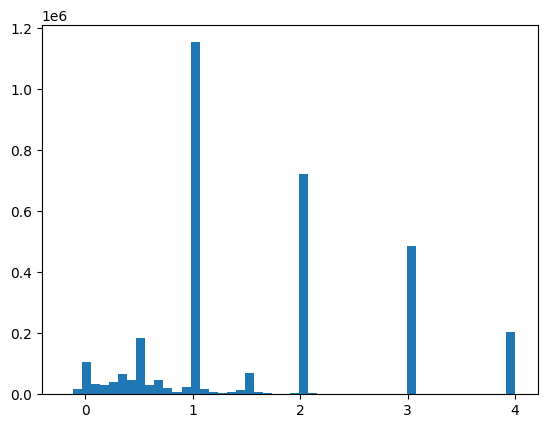

In [10]:
values = ITEM_DIFFS_SIM.data
plt.hist(values, bins=50)

In [12]:
item_sims = np.load('item_sims.npy')

(array([3.00000e+00, 3.00000e+00, 6.00000e+00, 6.00000e+00, 1.00000e+01,
        1.20000e+01, 2.10000e+01, 2.90000e+01, 2.00000e+01, 4.30000e+01,
        6.40000e+01, 8.20000e+01, 1.32000e+02, 1.83000e+02, 2.57000e+02,
        2.89000e+02, 4.30000e+02, 6.81000e+02, 9.96000e+02, 1.85700e+03,
        3.13200e+03, 4.36700e+03, 4.27000e+03, 2.11200e+03, 1.06889e+05,
        3.31400e+03, 1.99700e+03, 1.10900e+03, 1.46200e+03, 1.16400e+03,
        8.91000e+02, 5.57000e+02, 6.86000e+02, 4.46000e+02, 3.73000e+02,
        3.82000e+02, 4.19000e+02, 2.43000e+02, 1.29000e+02, 9.70000e+01,
        8.10000e+01, 6.90000e+01, 4.40000e+01, 4.00000e+01, 3.70000e+01,
        2.90000e+01, 2.20000e+01, 2.10000e+01, 1.80000e+01, 2.00000e+01]),
 array([-4.98530095e-02, -4.78560901e-02, -4.58591708e-02, -4.38622514e-02,
        -4.18653321e-02, -3.98684127e-02, -3.78714934e-02, -3.58745741e-02,
        -3.38776547e-02, -3.18807354e-02, -2.98838160e-02, -2.78868967e-02,
        -2.58899773e-02, -2.38930580e-02

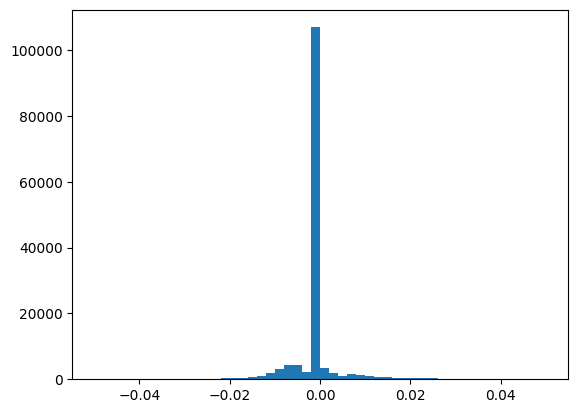

In [18]:
plt.hist(item_sims[(item_sims < 0.05) & (item_sims > -0.05)], bins=50)